In [1]:
import datatable as dt
import pandas as pd
import warnings
import numpy as np
from lightgbm import LGBMClassifier, plot_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
warnings.filterwarnings('ignore')

In [1]:
# Load and Preprocess Data
DATA_PATH = '../riiid-test-answer-prediction'
data = dt.fread(f"{DATA_PATH}/train.csv")
data = data.to_pandas()

target = 'answered_correctly'
columns = ['user_id', 'content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation']
data = data.loc[data['content_type_id']==False, columns+[target]]

user = data.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])
user['user_percent_correct'] = user['sum'] / user['count']
user.drop(columns=['sum'], inplace=True)

question = data.groupby('content_id')['answered_correctly'].agg(['sum', 'count'])
question['question_percent_correct'] = question['sum'] / question['count']
question.drop(columns=['sum', 'count'], inplace=True)

data = data.join(user, on='user_id')
data = data.join(question, on='content_id')
data.reset_index(drop=True, inplace=True)
data['prior_question_had_explanation'] = data['prior_question_had_explanation'].fillna(False).astype(np.int8)

In [2]:
# Create Pipelines
numeric_features = ['prior_question_elapsed_time', 'count', 'user_percent_correct', 'question_percent_correct']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['prior_question_had_explanation']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LGBMClassifier())])

X_train, X_test, y_train, y_test = train_test_split(data[numeric_features+categorical_features], 
                                                    data['answered_correctly'],
                                                    random_state=2020,
                                                    test_size=0.1
                                                   )

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  random_state=2020,
                                                  test_size=0.222
                                                  )

In [3]:
# Baseline Model
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print(roc_auc_score(y_val, y_pred))

0.6425432711621684


In [5]:
# LightGBM Model
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_val)
print(roc_auc_score(y_val, y_pred))

0.7568151393278345


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

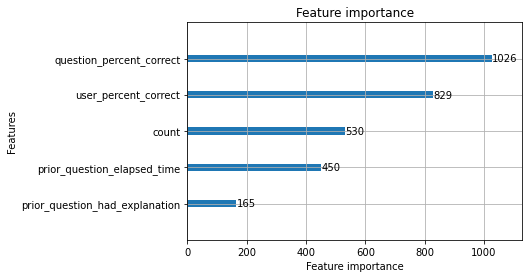

In [12]:
# Feature Importances
plot_importance(lgbm['classifierobtain'])

In [20]:
# LightGBM Parameters Tuning
space = [Real(0.01, 0.5, name='learning_rate', prior='log-uniform'),
         Integer(1, 30, name='max_depth'),
         Integer(10, 200, name='num_leaves'),
         Real(0.1, 1.0, name='feature_fraction', prior='uniform'),
         Real(0.1, 1.0, name='subsample', prior='uniform')
        ]

@use_named_args(space)
def objective(**params):
    lgbm['classifier'].set_params(**params)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_val)
    return -roc_auc_score(y_val, y_pred)

res_gp = gp_minimize(objective, space, n_calls=10, random_state=2020)

In [38]:
print("Best ROC-AUC = %.4f" % -res_gp.fun)
opt_params = {i.name:j for i, j in zip(space, res_gp.x)}
print("Optimized Parameters :", opt_params)

Best ROC-AUC = 0.7577
Optimized Parameters : {'learning_rate': 0.1661864399323458, 'max_depth': 22, 'num_leaves': 163, 'feature_fraction': 0.51938482949499, 'subsample': 0.4015477149296921}


In [40]:
# Optimized LightGBM Performance
# ROC-AUC
lgbm['classifier'].set_params(**opt_params)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.7579631854648538


In [41]:
# Accuracy
print(accuracy_score(y_test, y_pred))

0.7222391567351288


In [42]:
# Precision
print(precision_score(y_test, y_pred))

0.7452086750994887


In [43]:
# Recall
print(recall_score(y_test, y_pred))

0.877199706388983


In [44]:
# F1-Score
print(f1_score(y_test, y_pred))

0.8058351256741698
